In [1]:
!pip3 install -r requirements.txt --quiet

In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from datetime import date, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] =  (22,5)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
import warnings
warnings.filterwarnings('ignore')

In [3]:
symbol = 'GOOGL'
data = yf.Ticker(symbol)
#Fetching the records for the lifetime of the stock
data_hist = data.history(period="max")
##Skipping the dividend column
df = data_hist[["Open", "High", "Low", "Close", "Volume"]]
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19 00:00:00-04:00,2.496321,2.597672,2.395469,2.504808,893181924
2004-08-20 00:00:00-04:00,2.521534,2.722988,2.508803,2.703765,456686856
2004-08-23 00:00:00-04:00,2.764676,2.832825,2.722238,2.730976,365122512
2004-08-24 00:00:00-04:00,2.776908,2.785895,2.585440,2.617892,304946748
2004-08-25 00:00:00-04:00,2.620139,2.696027,2.593179,2.646101,183772044


In [4]:
# Calculate EWMAs
df['Close_EWMA_14'] = df['Close'].ewm(span=14).mean()

# Creating training and test sets
train = df[df.index.year < 2022]
test = df[df.index.year >= 2022]

# Ensure exogenous features are present in the train set
exog_features = ['Open', 'High', 'Low', 'Close_EWMA_14']

train = train[exog_features + ['Close'] ]
test = test[exog_features + ['Close']]
model = sm.tsa.arima.ARIMA(endog=train['Close'], exog=train[exog_features], order=(1, 1, 1))

In [5]:
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 4374
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -112.893
Date:                Sun, 22 Sep 2024   AIC                            239.786
Time:                        19:58:25   BIC                            284.468
Sample:                             0   HQIC                           255.553
                               - 4374                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open             -0.5358      0.006    -96.585      0.000      -0.547      -0.525
High              0.7039      0.005    143.346      0.000       0.694       0.714
Low               0.8027      0.004    185.376      0.000       0.794       0.811
Close_EWMA_14     0.0311      0.001     20.961      0.000       0.028       0.034
ar.L1            -0.1180      0.005    -22.956      0.000      -0.128      -0.108
ma.L1            -0.9982      0.001   -905.751      0.000      -1.000      -0.996
sigma2            0.0614      0.000    135.469      0.000       0.061       0.062
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):             46057.26
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):              24.00   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here’s a brief explanation of the key terms from the ARIMA model output:

1. **Log Likelihood**: A measure of how well the model explains the observed data; higher values indicate a better fit.

2. **AIC (Akaike Information Criterion)**: A criterion for model selection; lower values suggest a better model while penalizing for complexity (number of parameters).

3. **BIC (Bayesian Information Criterion)**: Similar to AIC but with a stronger penalty for models with more parameters; also used for model selection. 

4. **HQIC (Hannan-Quinn Information Criterion)**: Another criterion for model selection that falls between AIC and BIC in terms of penalty for complexity.

5. **Covariance Type**: Covariance is a statistical measure that indicates the extent to which two random variables change together. It shows the direction of the relationship between the variables. Covariance Type Indicates the method used to calculate the covariance of the parameter estimates (here, it’s "opg"). 

6. **coef**: The estimated coefficients for each predictor; they indicate the expected change in the dependent variable for a one-unit change in the predictor.

7. **std err**: The standard error of the estimated coefficients, indicating the variability of the estimate.

8. **z**: The z-score for each coefficient, which measures the number of standard deviations the coefficient is away from zero.

9. **P>|z|**: The p-value associated with the z-score, indicating the significance of each coefficient; values below 0.05 typically indicate significance.

10. **sigma²**: The estimated variance of the residuals, which indicates the variability of the errors in the model.

11. **Ljung-Box Test (Q)**: A statistical test to check for autocorrelation in the residuals; a low p-value suggests the presence of autocorrelation. Autocorrelation is the correlation of a time series with its own past values, measuring how current values are related to their previous values over various time lags.

12. **Jarque-Bera (JB)**: A test for normality of the residuals; a significant p-value suggests the residuals are not normally distributed.

13. **Heteroskedasticity (H)**: Indicates whether the variance of the residuals is constant; significant p-values suggest that the residuals exhibit heteroskedasticity, meaning they have non-constant variance.

14. **Skew**: A measure of the asymmetry of the distribution of the residuals; values close to zero indicate a symmetric distribution.

15. **Kurtosis**: Measures the "tailedness" of the distribution; high kurtosis indicates heavy tails, which can affect the normality of residuals.

In [6]:
# Log-likelihood
log_likelihood = model_fit.llf
print(f'Log-Likelihood: {log_likelihood}')

Log-Likelihood: -112.89282135742292


In [7]:
#Making Predictions and Calculating the prediction confidence and error term for each prediction
forecast = [model_fit.forecast(exog=test[exog_features].iloc[i]).values[0] for i in range(len(test))]
test['Forecast'] = np.around(np.array(forecast),2)
test['Confidence_Pct'] = np.around(1 /(1 + np.exp(-np.array(forecast)))*100,2)
test.index = [pd.to_datetime(test.index[i]).date() for i in range(len(test))]
test = test.reset_index().rename(columns={'index': 'Date'})
test['RMSE'] = np.sqrt(((test['Forecast'] - test['Close'])**2))
test.head()

,Date,Open,High,Low,Close_EWMA_14,Close,Forecast,Confidence_Pct,RMSE
0,2022-01-03,144.696697,145.490736,143.358016,145.188784,144.633362,144.57,100.0,0.063362
1,2022-01-04,145.036861,146.123175,143.361520,145.035991,144.042831,144.84,100.0,0.797169
2,2022-01-05,144.063284,144.142586,137.347917,144.022484,137.434692,139.10,100.0,1.665308
3,2022-01-06,136.660114,139.594346,136.221199,143.140454,137.407257,138.94,100.0,1.532743
4,2022-01-07,137.804265,138.106526,135.431144,142.278868,136.678558,136.62,100.0,0.058558


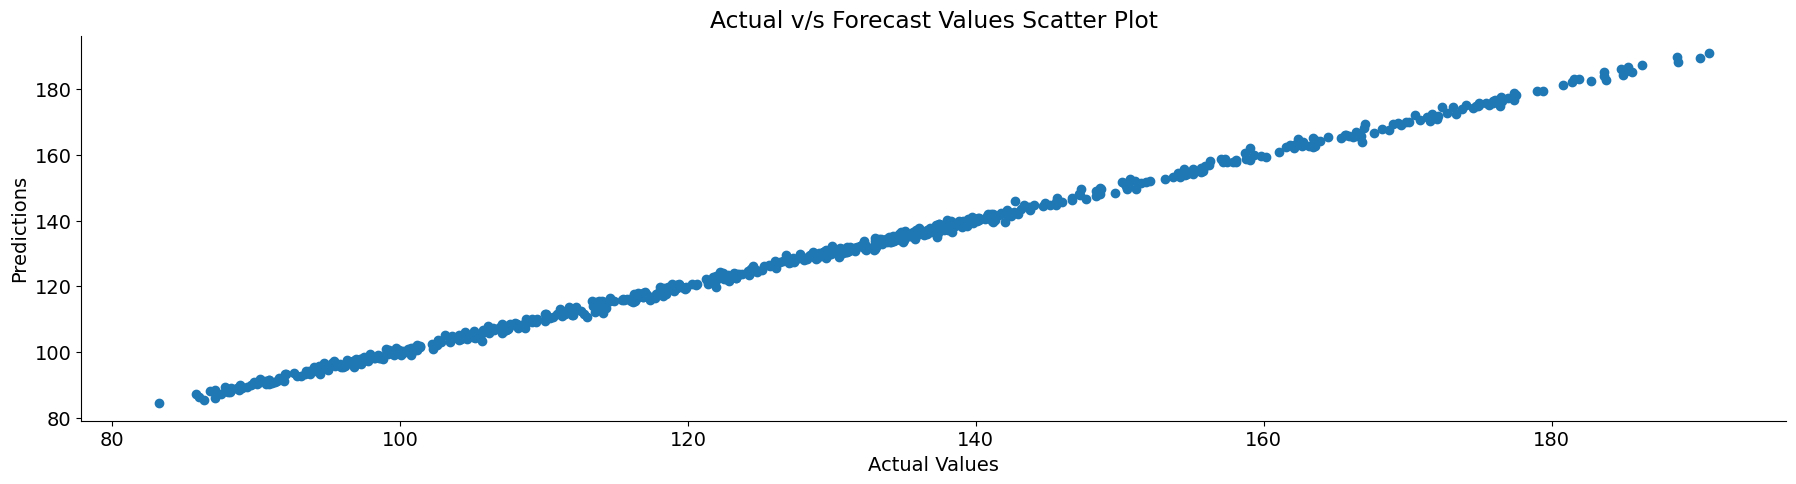

In [8]:
plt.scatter(test['Close'], test['Forecast'])
plt.title('Actual v/s Forecast Values Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.show()

![image](https://media.geeksforgeeks.org/wp-content/uploads/20200622171741/RMSE1.jpg)

In [9]:
rmse =  round(test['RMSE'].mean(),4)
conf_pct = float(test['Confidence_Pct'].mean())
print(f"The RMSE for the predictions is {rmse} and the model is {conf_pct}% confident on its predictions.")

The RMSE for the predictions is 0.7053 and the model is 100.0% confident on its predictions.


In [10]:
test.to_csv('predictions.csv', index=False)